## Notebook requiers a lot of RAM. So save data and reload notebook on HDD.(already implemented)

In [1]:
import numpy as np

from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.layers import Input, Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Dense, AveragePooling2D, BatchNormalization
from keras.activations import relu
from keras.regularizers import l2
from keras.optimizers import *
from keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMG_SZ = (64, 64)
N_LABELS = 1000
BATCH_SZ = 64

In [ ]:
d_part_1 = np.load("../data/train/train-1.npy")
print("train-1.npy is loaded")
d_part_2 = np.load("../data/train/train-2.npy")
print("train-2.npy is loaded")
d_part_3 = np.load("../data/train/train-3.npy")
print("train-3.npy is loaded")
d_part_4 = np.load("../data/train/train-4.npy")
print("train-4.npy is loaded")

In [ ]:
data_train = np.concatenate((d_part_1, d_part_2, d_part_3, d_part_4), axis=0)
labels = data_train[:, 1].reshape(-1, 1)

In [ ]:
plt.figure(9, (8, 8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(data_train[i][0], cmap='gray')

In [ ]:
IMG_SZ = (64, 64)
hieroglyphs = np.empty((data_train.shape[0], IMG_SZ[0], IMG_SZ[1]))

for i in tqdm(range(hieroglyphs.shape[0])):
    hieroglyphs[i] = resize(data_train[i][0], IMG_SZ)

In [ ]:
hieroglyphs -= hieroglyphs.mean(axis=0)

In [ ]:
np.save("../data/train/hier.npy", hieroglyphs)
np.save("../data/train/labels.npy", labels)

In [ ]:
hieroglyphs = np.load("../data/train/hier.npy")
labels = np.load("../data/train/labels.npy")

In [ ]:
enc = OneHotEncoder()
enc.fit(labels)
one_hot_l = enc.transform(labels).toarray()

X_train, X_test, y_train, y_test = train_test_split(hieroglyphs, 
                                                    one_hot_l, 
                                                    test_size=0.15, 
                                                    random_state=42)

In [ ]:
np.save("../data/train/X_train.npy", X_train)
np.save("../data/train/X_test", X_test)
np.save("../data/train/y_train.npy", y_train)
np.save("../data/train/y_test.npy", y_test)
np.save("../data/train/map.npy", enc.active_features_)

In [3]:
X_train = np.load("../data/train/X_train.npy")
X_test = np.load("../data/train/X_test.npy")
y_train = np.load("../data/train/y_train.npy")
y_test = np.load("../data/train/y_test.npy")
act_features = np.load("../data/train/map.npy")

In [4]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [6]:
# Use this cell for training on full dataset
# X_train = np.concatenate([X_train, X_test], axis=0)
# y_train = np.concatenate([y_train, y_test], axis=0)

In [7]:
def cnn(input1_shape, n_classes):
    inp_1 = Input(shape=input1_shape, name="Input_1")
    
    leaky_relu = lambda x: relu(x, alpha=5.0e-2)
    regularization_coef = 1.0e-4
    
    drop_1 = Dropout(0.2)(inp_1)
    con_1 = Convolution2D(
        filters=64,                  
        kernel_size=(5, 5),
        padding='same',
        activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name="Convolution_1"
    )(drop_1)
    btch_1 = BatchNormalization(axis=3, name="BatchNorm_1")(con_1)
    
    con_2 = Convolution2D(
        filters=64,                  
        kernel_size=(5, 5),
        padding='same',
        activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name="Convolution_2"
    )(btch_1)
    btch_2 = BatchNormalization(axis=3, name="BatchNorm_2")(con_2)
    pool_1 = MaxPooling2D(pool_size=(2, 2), name="MaxPooling_1")(btch_2)
    
    drop_2 = Dropout(0.2)(pool_1)
    con_3 = Convolution2D(
        filters=128,                  
        kernel_size=(5, 5),
        padding='same',
        activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name="Convolution_3"
    )(drop_2)
    btch_3 = BatchNormalization(axis=3, name="BatchNorm_3")(con_3)
    
    con_4 = Convolution2D(
        filters=128,           
        kernel_size=(5, 5),
        padding='same',
        activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name="Convolution_4"
    )(btch_3)
    btch_4 = BatchNormalization(axis=3, name="BatchNorm_4")(con_4)
    pool_2 = MaxPooling2D(pool_size=(2, 2), name='MaxPooling_2')(btch_4)
    
    drop_3 = Dropout(0.2)(pool_2)
    con_5 = Convolution2D(
        filters=256,                  
        kernel_size=(5, 5),
        padding='same',
        activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name="Convolution_5"
    )(drop_3)
    btch_5 = BatchNormalization(axis=3, name="BatchNorm_5")(con_5)
    pool_3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='MaxPooling2D_3')(btch_5)
    
    flat_1 = Flatten()(pool_3)
    
    drop_4 = Dropout(0.5)(flat_1)
    den_1 = Dense(
        units = 3000,
        activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name="Dense_1"
    )(drop_4)
    
    drop_5 = Dropout(0.5)(den_1)
    den_2 = Dense(
        units = 2500,
        activation=leaky_relu,
        kernel_regularizer=l2(regularization_coef),
        name="Dense_2"
    )(drop_5)
    
    drop_6 = Dropout(0.5)(den_2)
    den_3 = Dense(
        units = n_classes,
        activation="softmax",
        kernel_regularizer=l2(regularization_coef),
        name="Dense_3"
    )(drop_6)
    
    return Model(inputs=inp_1, outputs=den_3)

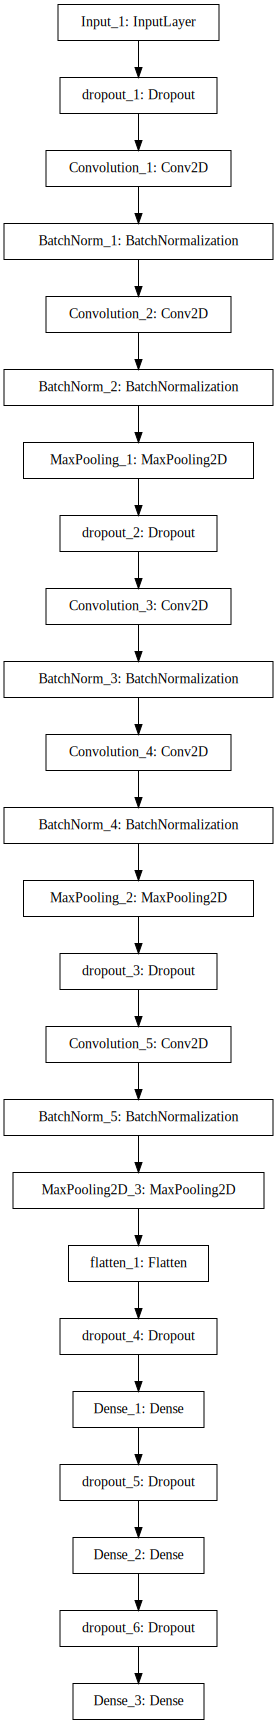

In [8]:
net = cnn_4(input1_shape=(64, 64, 1), n_classes=N_LABELS)

SVG(model_to_dot(net, show_layer_names=True, show_shapes=False).create(prog='dot', format='svg'))

In [9]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 1)         0         
_________________________________________________________________
Convolution_1 (Conv2D)       (None, 64, 64, 64)        1664      
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 64, 64, 64)        256       
_________________________________________________________________
Convolution_2 (Conv2D)       (None, 64, 64, 64)        102464    
_________________________________________________________________
BatchNorm_2 (BatchNormalizat (None, 64, 64, 64)        256       
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 32, 32, 64)        0         
__________

In [10]:
net.compile(optimizer=Adadelta(), loss=categorical_crossentropy, metrics=['accuracy'])

In [21]:
net.fit(x=X_train,
        y=y_train,
        batch_size=BATCH_SZ * 2,
        epochs=3)

Epoch 1/3
332987/332987 [==============================] - 1513s 5ms/step - loss: 1.3837 - acc: 0.9720
Epoch 2/3
332987/332987 [==============================] - 1513s 5ms/step - loss: 1.4383 - acc: 0.9723
Epoch 3/3
332987/332987 [==============================] - 1513s 5ms/step - loss: 1.4878 - acc: 0.9722


In [ ]:
y_pred_train = net.predict(x=X_train,
                           batch_size=BATCH_SZ)

y_pred_test = net.predict(x=X_test,
                          batch_size=BATCH_SZ)

In [ ]:
pred_train_l = np.argmax(y_pred_train, axis=1)
y_train_l = np.argmax(y_train, axis=1)
accuracy_train = np.equal(pred_train_l, y_train_l).mean() * 100

pred_test_l = np.argmax(y_pred_test, axis=1)
y_test_l = np.argmax(y_test, axis=1)
accuracy_test = np.equal(pred_test_l, y_test_l).mean() * 100

print("Accuracy on train %f"%accuracy_train)
print("Accuracy on test %f"%accuracy_test)

In [12]:
data_predic = np.load("../data/test/test.npy").reshape(-1, 1)
print("test.npy is loaded")

test.npy is loaded


In [13]:
predic_rszd = np.empty((data_predic.shape[0], IMG_SZ[0], IMG_SZ[1]))

for i in range(predic_rszd.shape[0]):
    predic_rszd[i] = resize(data_predic[i][0], IMG_SZ)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [14]:
predic_rszd -= predic_rszd.mean(axis=0)

In [ ]:
np.save("../data/test/data_predic.npy", predic_rszd)

In [ ]:
predic_rszd = predic_rszd.reshape((predic_rszd.shape[0],
                                   predic_rszd.shape[1],
                                   predic_rszd.shape[2],
                                   1))

kag_pred = net.predict(x=predic_rszd, batch_size=BATCH_SZ)

In [ ]:
kag_pred = np.argmax(kag_pred, axis=1).reshape(-1, 1)

In [ ]:
for i in range(kag_pred.shape[0]):
    kag_pred[i] = act_features[kag_pred[i]]

In [ ]:
ind = np.asarray(list(range(1, kag_pred.shape[0] + 1))).reshape(-1, 1)

In [ ]:
ind = np.concatenate((ind, kag_pred), axis=1)

In [ ]:
np.savetxt("res.csv", ind, delimiter=',', fmt="%d", header="Id,Category", comments="")